In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier as DecisionTreeClassifier_sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.tree import plot_tree

* What is the tree structure? 
    + Root node: no parent nodes
    + Leaf node: no child nodes
    + Intermediate node
* How to use the tree for classification?
    + What does each node need to include?
    + How to construct a criterion to measure the quality of a split?

What does each node need to include for different [Decision Tree Algorithms](https://scikit-learn.org/stable/modules/tree.html)?
* ID3 (Iterative Dichotomiser 3) 
    + Tree structure: A multiway tree. It "converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules"
    + Criteria: Information gain for categorical targets
    <!-- + Find for each node in a greedy manner -->
    + Categorical feature 


* C4.5 (Successor of ID3)
    + Can use continuous features: remove the restriction in ID3 that "features must be categorical by dynamically defining a discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete set of intervals"
    <!-- + "The accuracy of each rule is then evaluated to determine the order in which they should be applied" -->


* CART (Classification and Regression Tree) using Gini impurity: it supports numerical target variables (regression) 
    + Tree structure: binary trees 
    + Criteria: Information gain
    + Find the feature and threshold that yield the largest information gain at each node    

* What are the paramters for this algorithm?
 <!-- Feature for splitting, split criterion, samples, final/temporary decision, tree structure (the number of child nodes)-->

### Criteria
* Gini impurity $=1-\sum_{j=1}^c p_j^2$
*  Entropy $=\sum_{i=1}^c-p_i \log _2 p_i$
<!-- * Information gain =entropy (parent)-[weightes average] * entropy (children) -->




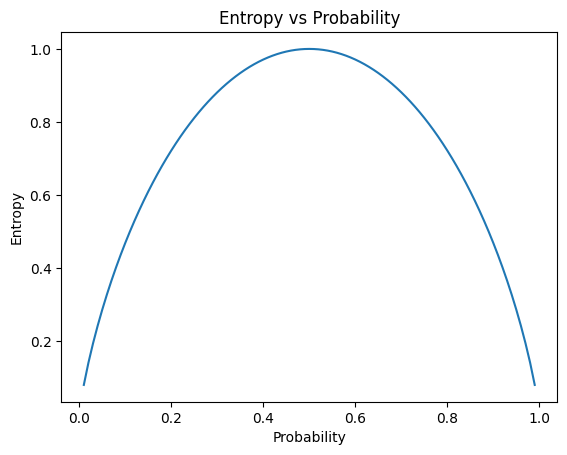

In [67]:
def entropy( y):
    """Calculate the entropy for a list of classes.
    Equation: H(Y) = -Σ Pr(Y=yc) * log2(Pr(Y=yc))
    args:
        y: a list of values for ground truths (classes)
    """
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

    
# entropy values for each probability
probabilities = np.arange(0.01, 1.0, 0.01)
entropy_values = [-p*np.log2(p) - (1-p)*np.log2(1-p) for p in probabilities]
plt.plot(probabilities, entropy_values)
plt.title("Entropy vs Probability")
plt.xlabel("Probability")
plt.ylabel("Entropy")
plt.show()



# def gini_impurity(y):
#     """Calculate the gini impurity for a list of classes.
#     Equation: Gini(Y) = 1 - Σ Pr(Y=yc)^2
#     args:
#         y: a list of classes
#     """
#     # count the occurrences of each class
#     hist = np.bincount(y)
#     # and then calculate the gini impurity
#     impurity = 1 - np.sum([(i / len(y)) ** 2 for i in hist])
#     return impurity

# # gini impurity values for each probability
# gini_values = [gini_impurity([1]*int(p*100) + [0]*int((1-p)*100)) for p in probabilities]
# plt.plot(probabilities, gini_values)
# plt.title("Gini Impurity vs Probability")
# plt.xlabel("Probability")
# plt.ylabel("Gini Impurity")
# plt.show()

### Feature Importance

In [108]:
# read titanic data
titanic_df = pd.read_csv('data/titanic_cleaned_data.csv')

# define X and y
# Port of Embarkation: Q = Queenstown, S = Southampton
feature_cols = ['Pclass', 'Sex', 'Embarked_Q', 'Embarked_S']
feature_idx2name = {i: col for i, col in enumerate(feature_cols)}
X = titanic_df[feature_cols]
y = titanic_df.Survived
X = X.to_numpy()
y = y.to_numpy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)


In [102]:
def information_gain(y_parent, left_child, right_child):
    """Calculate the information gain from a parent to its children.
    Equation: IG(Y, X) = H(Y) - Σ |Yv| / |Y| * H(Yv), where X is the feature, Y is the parent node, and Yv is the child node of X = V.
    args:
        y_parent: a list of classes representing the parent node
        left_child: a list of classes representing the left child node
        right_child: a list of classes representing the right child node
    """
    # calculate the entropy of the parent
    parent_entropy = entropy(y_parent)
    # calculate the entropy of the children
    left_entropy = entropy(left_child)
    right_entropy = entropy(right_child)
    # calculate the information gain
    p = float(len(left_child)) / (len(left_child) + len(right_child))
    gain = parent_entropy - p * left_entropy -  (1 - p)* right_entropy
    return gain

In [103]:
def feature_importance(X, y, feature):
    possible_thresholds = np.unique(X[:, feature])
    best_gain = 0
    best_threshold = None
    for threshold in possible_thresholds:
        left = y[X[:, feature] <= threshold]
        right = y[X[:, feature] > threshold]
        if len(left) == 0 or len(right) == 0:
            continue
        gain = information_gain(y, left, right)
        if gain > best_gain:

            best_gain = gain
            best_threshold = threshold
    return best_gain, best_threshold

### Splits

In [124]:
import numpy as np
from collections import deque

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def fit(self, X, y, feature_idx2name =None):
        self.tree = self._build_tree_breadth_first(X, y, feature_idx2name)

    def _build_tree_depth_first(self, X, y, feature_idx2name=None, depth=0):
        assert type(X) == np.ndarray
        assert type(y) == np.ndarray

        num_samples = X.shape[0]
        if num_samples <= 1 or len(set(y)) == 1 or (self.max_depth and depth >= self.max_depth):
            leaf_value = self._most_common_label(y)
            return self.Node(value=leaf_value)

        # Compute the information gain for each feature and choose the best one
        best_feature_idx, best_threshold = self._best_criteria(X, y, X.shape[1])
        if feature_idx2name:
            print(f'Depth: {depth}, Best feature: {feature_idx2name[best_feature_idx]}, Best threshold: {best_threshold}')
            print('\n')
        
        left_idxs, right_idxs = self._split(X[:, best_feature_idx], best_threshold)
        left_subtree = self._build_tree(X[left_idxs, :], y[left_idxs],  feature_idx2name, depth+1)
        right_subtree = self._build_tree(X[right_idxs, :], y[right_idxs], feature_idx2name, depth+1)
        return self.Node(best_feature_idx, best_threshold, left_subtree, right_subtree)
    
    def _build_tree_breadth_first(self, X, y, feature_idx2name=None):
        queue = deque()
        root = self.Node()
        queue.append((root, X, y, 0))  # Node, features, target, depth

        while queue:
            current_node, data, labels, depth = queue.popleft()

            if len(np.unique(labels)) == 1 or depth == self.max_depth:
                current_node.value = self._most_common_label(labels)
                continue

            best_feature_idx, best_threshold = self._best_criteria(data, labels, X.shape[1])
            if feature_idx2name:
                print(f'Depth: {depth}, Best feature: {feature_idx2name[best_feature_idx]}, Best threshold: {best_threshold}')
                print('\n')
            if best_feature_idx is None:
                current_node.value = self._most_common_label(labels)
                continue

            left_idxs, right_idxs = self._split(data[:, best_feature_idx], best_threshold)
            current_node.feature = best_feature_idx
            current_node.threshold = best_threshold
            current_node.left = self.Node()
            current_node.right = self.Node()

            queue.append((current_node.left, data[left_idxs, :], labels[left_idxs], depth + 1))
            queue.append((current_node.right, data[right_idxs, :], labels[right_idxs], depth + 1))

        return root

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

    def _predict(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict(x, node.left)
        return self._predict(x, node.right)

    def _best_criteria(self, X, y, num_features):
        best_gain = -1
        select_feature, select_threshold = None, None
        for feature in range(num_features):
            gain, threshold = feature_importance(X, y, feature)
            if gain > best_gain:
                best_gain = gain
                select_feature, select_threshold = feature, threshold
        
        return select_feature, select_threshold

    def _split(self, feature, threshold):
        left_idxs = np.where(feature <= threshold)[0]
        right_idxs = np.where(feature > threshold)[0]
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        return np.bincount(y).argmax()


In [125]:
treeclf = DecisionTreeClassifier(max_depth=3)
treeclf.fit(Xtrain, ytrain, feature_idx2name)
print("Training accuracy: {}".format(accuracy_score(ytrain, treeclf.predict(Xtrain))))
print("Testing accuracy : {}".format(accuracy_score(ytest, treeclf.predict(Xtest))))


0.0442039183434666 1
0.06758090051040033 2
0.20726432072439444 0
3.6304658943345225e-05 0
0.020122835997773314 0
Depth: 0, Best feature: Sex, Best threshold: 0


0.0899301600657596 1
0.24561559365157337 2
0.00023350289823759196 0
0.021937776039196222 0
Depth: 1, Best feature: Pclass, Best threshold: 2


0.01843007090145543 1
0.01204644461836274 2
0.003539629225168761 0
0.006567979670606017 0
Depth: 1, Best feature: Pclass, Best threshold: 1


0.004456596411002961 1
0.000980734154840207 0
0.0006083375660913548 0
Depth: 2, Best feature: Pclass, Best threshold: 1


0.05089788306306056 0
0.08525777022961245 0
Depth: 2, Best feature: Embarked_S, Best threshold: 0


0.007203726785066755 0
0.0321770257558297 0
Depth: 2, Best feature: Embarked_S, Best threshold: 0


0.0013196692680219058 2
0.0017518499260417916 0
0.0007257899766219267 0
Depth: 2, Best feature: Embarked_Q, Best threshold: 0


Training accuracy: 0.8170144462279294
Testing accuracy : 0.7985074626865671


In [53]:
# treeclf = DecisionTreeClassifier_sklearn(max_depth=3, random_state=1)
# treeclf.fit(Xtrain, ytrain)
# print("Training accuracy: {}".format(accuracy_score(ytrain, treeclf.predict(Xtrain))))
# print("Testing accuracy : {}".format(accuracy_score(ytest, treeclf.predict(Xtest))))

In [ ]:

tree_ds = treeclf.tree_
print("Number of nodes: {}".format(tree_ds.node_count))
print("Max depth: {}".format(tree_ds.max_depth))

node_idx = 0
# the entire binary tree structure, represented as a number of parallel arrays
print(f"Feature of each node: {tree_ds.feature[node_idx]}")

# the threshold of each node
print(f"Threshold of each node: {tree_ds.threshold[node_idx]}")

# the child of each node
print(f"Children of node {node_idx}: {tree_ds.children_left[node_idx]}, {tree_ds.children_right[node_idx]}")

# the impurity at each node
print(tree_ds.impurity[node_idx])

# calculate gini impurity for the root node
print("The gini impurity for the root node is: ", gini_impurity(ytrain))


# split the data by Pclass
Xtrain_1 = Xtrain[Xtrain['Pclass'] == 1]
ytrain_1 = ytrain[Xtrain['Pclass'] == 1]
Xtrain_2 = Xtrain[Xtrain['Pclass'] == 2]
ytrain_2 = ytrain[Xtrain['Pclass'] == 2]
Xtrain_3 = Xtrain[Xtrain['Pclass'] == 3]
ytrain_3 = ytrain[Xtrain['Pclass'] == 3]

# calculate gini impurity for each split
print("The gini impurity for the split on Pclass = 1 is: ", gini_impurity(ytrain_1))
print("The gini impurity for the split on Pclass = 2 is: ", gini_impurity(ytrain_2))
print("The gini impurity for the split on Pclass = 3 is: ", gini_impurity(ytrain_3))

# Average gini impurity for the split
print("The average gini impurity for the split on Pclass is: ", (len(ytrain_1) * gini_impurity(ytrain_1) + len(ytrain_2) * gini_impurity(ytrain_2) + len(ytrain_3) * gini_impurity(ytrain_3)) / len(ytrain))



# split the data by Sex
Xtrain_1 = Xtrain[Xtrain['Sex'] == 1]
ytrain_1 = ytrain[Xtrain['Sex'] == 1]
Xtrain_2 = Xtrain[Xtrain['Sex'] == 0]
ytrain_2 = ytrain[Xtrain['Sex'] == 0]

# calculate gini impurity for each split
print("The gini impurity for the split on Sex = 1 is: ", gini_impurity(ytrain_1))
print("The gini impurity for the split on Sex = 0 is: ", gini_impurity(ytrain_2))

# Average gini impurity for the split
print("The average gini impurity for the split on Pclass is: ", (len(ytrain_1) * gini_impurity(ytrain_1) + len(ytrain_2) * gini_impurity(ytrain_2) ) / len(ytrain))


In [ ]:
# plt.figure(figsize=(20,18))
# tree.plot_tree(treeclf, feature_names=feature_cols, class_names=['Died', 'Survived'], filled=True)
# plt.show()

The effect of max_depth

Text(0.5, 1.0, 'Accuracy comparison of training/validation set')

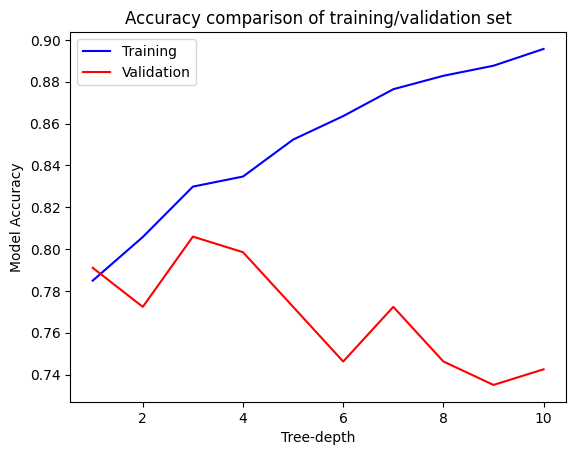

In [44]:
# depth takes values from 1 to 10
max_depth_range = range(1, 11)

valid_scores = []
train_scores = []
for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    treeclf.fit(Xtrain, ytrain)

    scores = accuracy_score(ytest, treeclf.predict(Xtest))
    scores2 = accuracy_score(ytrain, treeclf.predict(Xtrain))

    valid_scores.append(scores)
    train_scores.append(scores2)
    
valid_scores = np.array(valid_scores)
train_scores = np.array(train_scores)
# print(f"The size of evaluation data is {len(ytest)}")



plt.plot(max_depth_range, train_scores, color="blue", linewidth=1.5, label="Training")
plt.plot(max_depth_range, valid_scores, color="red", linewidth=1.5, label="Validation")
plt.legend(loc="upper left")
plt.xlabel("Tree-depth")
plt.ylabel("Model Accuracy")
plt.title("Accuracy comparison of training/validation set")


Text(0.5, 1.0, 'Accuracy comparison of training/validation set')

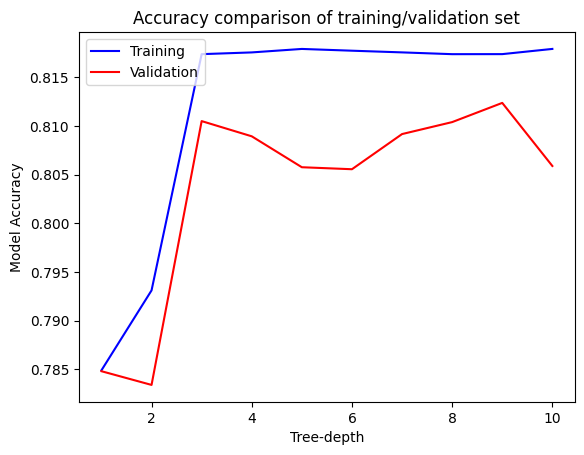

In [32]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)

# depth takes values from 1 to 10
max_depth_range = range(1, 11)

# do 10-fold cross-validation for each value in max_depth_range and return the accuracy scores. 
# store the mean value for each fold
valid_scores = []
train_scores = []
for depth in max_depth_range:
    treeclf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    treeclf.fit(Xtrain, ytrain)

    
    
    # do cross validation via Kfold
    scores = cross_val_score(treeclf, Xtrain, ytrain, cv=10, scoring='accuracy')
    scores = []
    scores2 = []
    for train_index, test_index in kf.split(Xtrain):
        X_train, X_test = Xtrain.iloc[train_index], Xtrain.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        treeclf.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, treeclf.predict(X_test)))
        scores2.append(accuracy_score(y_train, treeclf.predict(X_train)))
    
    valid_scores.append(scores)
    train_scores.append(scores2)
valid_scores = np.array(valid_scores)
train_scores = np.array(train_scores)

# Simple API for plotting a validation curve given training and validation scores.
# train_scores, valid_scores = validation_curve( treeclf, Xtrain, ytrain, param_name="max_depth", param_range=max_depth_range, cv=10, scoring="accuracy")

# Mean accuracy score for each value of max-depth
train_scores = np.mean(train_scores, axis=1)
valid_scores   = np.mean(valid_scores, axis=1)

plt.plot(max_depth_range, train_scores, color="blue", linewidth=1.5, label="Training")
plt.plot(max_depth_range, valid_scores, color="red", linewidth=1.5, label="Validation")
plt.legend(loc="upper left")
plt.xlabel("Tree-depth")
plt.ylabel("Model Accuracy")
plt.title("Accuracy comparison of training/validation set")


How to prevent the model from overfitting to the training set?
1. Use smaller tree-depth
2. Pre-pruning
    + Stop splitting nodes when the entropy reduction is not significant
    <!-- Sometimes attributes individually do not contribute much to a decision, but combined, they may have a significant impact -->
    + In Sk-learn, set parameters `min_samples_split` and `min_samples_leaf `
    + Difference between `min_samples_split` and `min_samples_leaf `
    <!-- + the distinction between a leaf (also called external node) and an internal node. An internal node will have further splits (also called children), while a leaf is by definition a node without any children (without any further splits).
    + min_samples_split specifies the minimum number of samples required to split an internal node, while min_samples_leaf specifies the minimum number of samples required to be at a leaf node.
    + For instance, if min_samples_split = 5, and there are 7 samples at an internal node, then the split is allowed. But let's say the split results in two leaves, one with 1 sample, and another with 6 samples. If min_samples_leaf = 2, then the split won't be allowed (even if the internal node has 7 samples) because one of the leaves resulted will have less then the minimum number of samples required to be at a leaf node. -->
3. Post-pruning
    + "wait until the full decision tree has been built, then go for subtrees and check whether you can replace it with a single node or feature, while incurring only a small amount of change in Entropy."

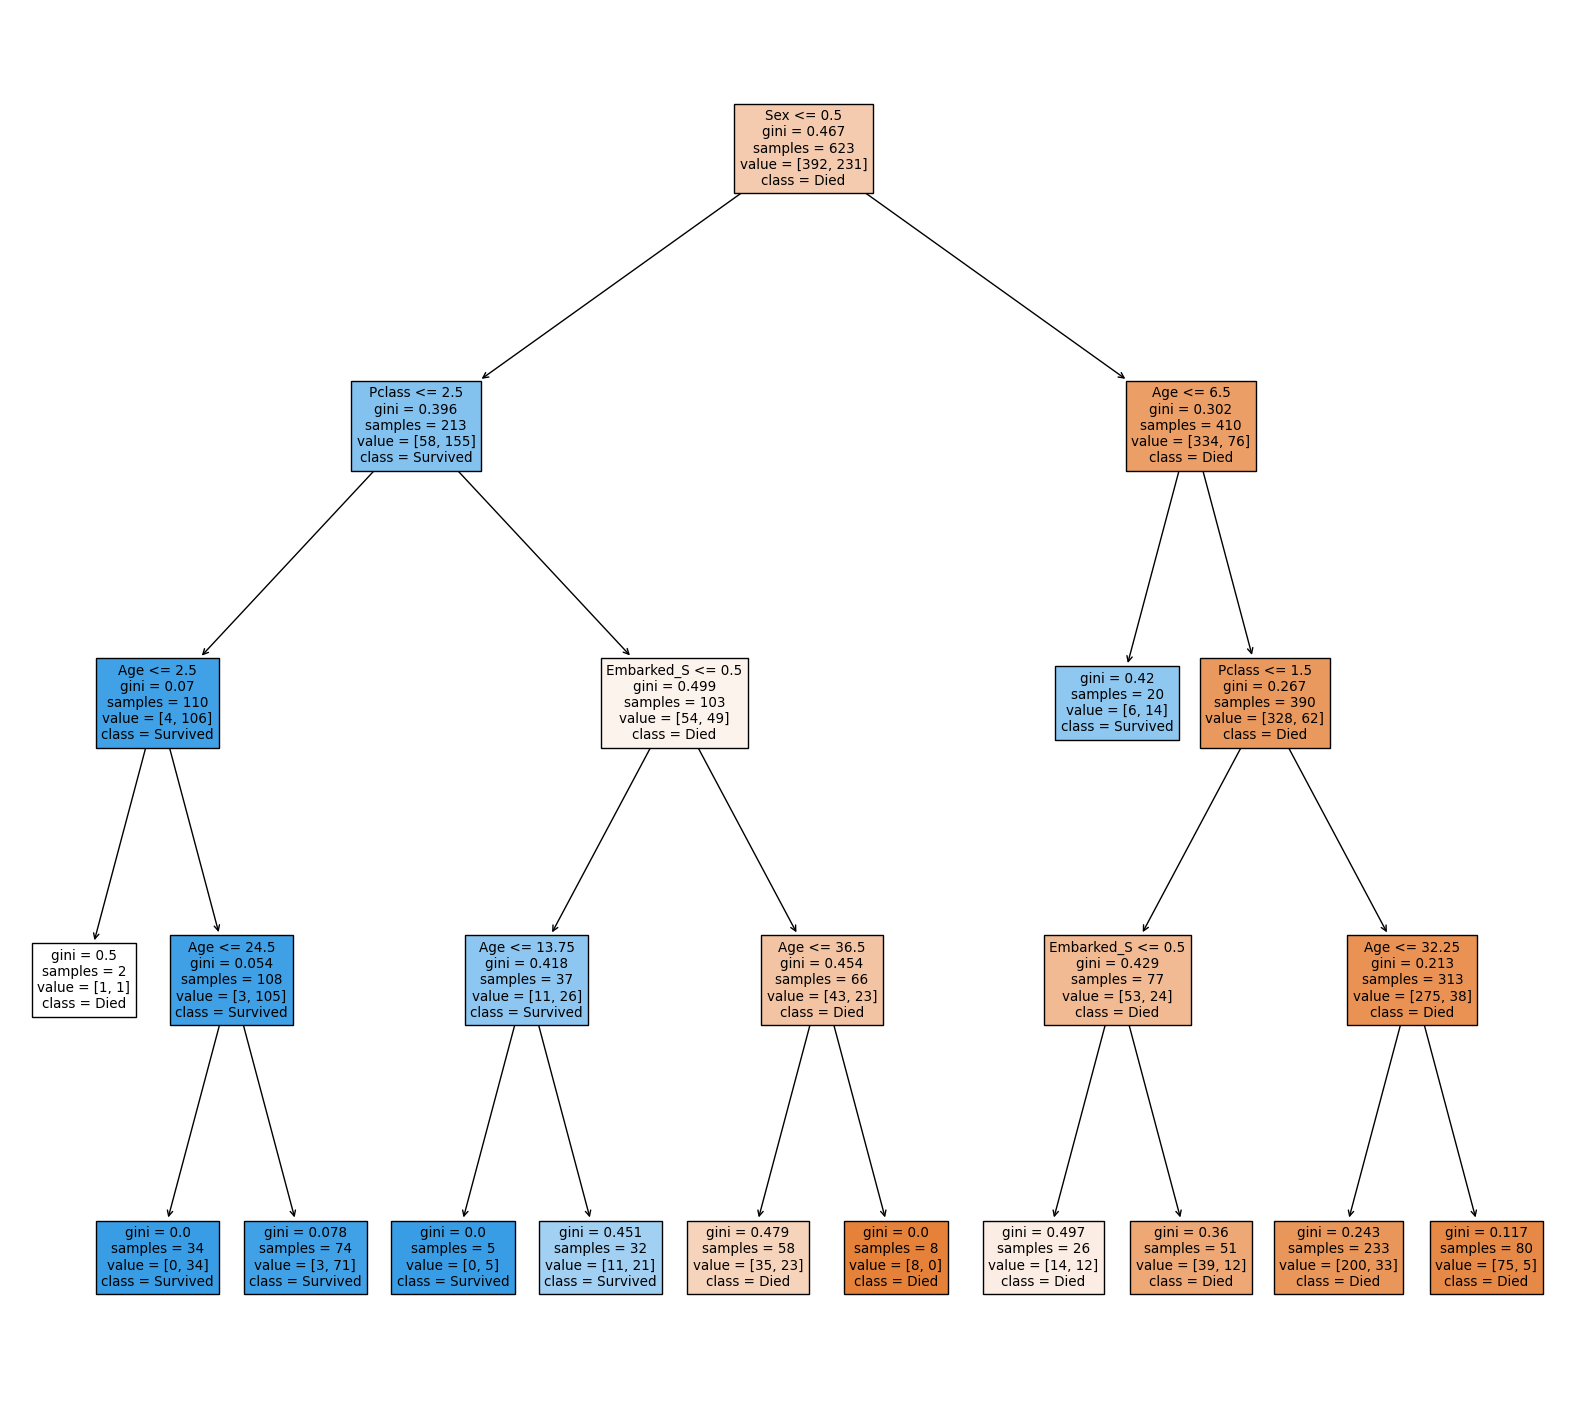

In [40]:
treeclf = DecisionTreeClassifier(max_depth=4, random_state=1,  min_samples_split=37)
treeclf.fit(Xtrain, ytrain)
plt.figure(figsize=(20,18))
tree.plot_tree(treeclf, feature_names=feature_cols, class_names=['Died', 'Survived'], filled=True)
plt.show()

Post-pruning
* [Cost complexity pruning](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning)
    + [Code](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

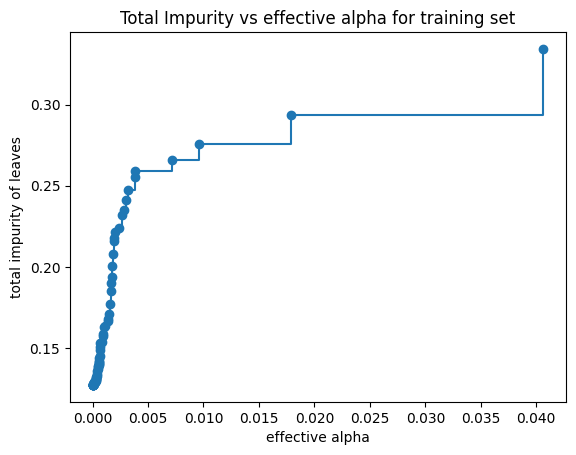

In [10]:
clf = DecisionTreeClassifier(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [16]:
# the last value in ccp_alphas is the alpha value that prunes the whole tree
for i in range(1, len(ccp_alphas)):
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[-i])
    clf.fit(X_train, y_train)
    print(
        "Number of nodes is: {} with ccp_alpha: {} and impurity: {}".format(
            clf.tree_.node_count, ccp_alphas[-i], impurities[-i]
        )
    )

Number of nodes is: 1 with ccp_alpha: 0.13235809539273619 and impurity: 0.46660775154652195
Number of nodes is: 3 with ccp_alpha: 0.040650744549143095 and impurity: 0.33424965615378577
Number of nodes is: 5 with ccp_alpha: 0.017876742787677258 and impurity: 0.2935989116046427
Number of nodes is: 7 with ccp_alpha: 0.009549734105204807 and impurity: 0.27572216881696543
Number of nodes is: 9 with ccp_alpha: 0.007183074653164256 and impurity: 0.2661724347117606
Number of nodes is: 11 with ccp_alpha: 0.0038523274478330666 and impurity: 0.25898936005859635
Number of nodes is: 13 with ccp_alpha: 0.003823891464340902 and impurity: 0.25513703261076326
Number of nodes is: 17 with ccp_alpha: 0.0032066195884192933 and impurity: 0.24748924968208144
Number of nodes is: 21 with ccp_alpha: 0.00302330093662357 and impurity: 0.24107601050524285
Number of nodes is: 25 with ccp_alpha: 0.0028297639476942554 and impurity: 0.23502940863199573
Number of nodes is: 27 with ccp_alpha: 0.0026535363614015295 and i

* Compared to Logistic Regression and SVM?
    + Non-parametric method: no functional form of underlying data distribution
    + Explicit decision rules or a piecewise constant approximation